# A continuación se encuentra el código utilizado para el trabajo práctico que tiene como objetivo realizar un análisis descriptivo y exploratorio de un dataset que contiene información climática de Australia brindado por la cátedra, junto con la implementación de un modelo para la predicción de la variable "RainTomorrow" que indica si el día siguiente lloverá o no.

## Consigna 1

### Librerías a utilizar durante el trabajo

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier ## importamos un bosque
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
## cross_val_score se encarga de ejecutar la validación cruzada, el resto son técnicas para hacerlo
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, LeaveOneOut

In [85]:
df = pd.read_csv('weatherAUS.csv')

Descripción de las variables a utilizar en el trabajo práctico y rango de variación de las mismas:

*   Date: Fecha de la observación meteorológica.
*   Location: Nombre o código de la estación meteorológica.
*   MinTemp: Temperatura mínima registrada en grados Celsius (-8, 30.3).
*   MaxTemp: Temperatura máxima registrada en grados Celsius (4.1, 46.9).
*   Rainfall: Cantidad de lluvia registrada en milímetros (0, 192).
*   Evaporation: Evaporación de agua en milímetros (0, 86.2).
*   Sunshine: Se registraron horas de sol brillante (0, 14.3).
*   WindGustDir: Velocidad máxima de las ráfagas de viento en kilómetros por hora (7, 126).
*   WindDir9am: Velocidad del viento a las 9 am en kilómetros por hora (0, 87).
*   WindDir3pm: Velocidad del viento a las 3 pm en kilómetros por hora (0, 72).
*   Humidity9am: Humedad relativa a las 9 am en porcentaje (1, 100).
*   Humidity3pm: Humedad relativa a las 3 pm en porcentaje (1, 100).
*   Pressure9am: Presión atmosférica a las 9 am en hPa (986.2, 1040.6).
*   Pressure3pm: Presión atmosférica a las 3 pm en hPa (982.6, 1037.9).
*   Cloud9am: Nubosidad a las 9 am en octavas (0, 9).
*   Cloud3pm: Nubosidad a las 3 p.m. en octavas (0, 8).
*   Temp9am: Temperatura a las 9 am en grados Celsius (-1.3, 39.4).
*   Temp3pm: Temperatura a las 3 pm en grados Celsius (3.7, 46.2).
*   RainToday: Variable binaria que indica si llovió hoy (1 para "Sí", 0 para "No").

Nuestra variable de salida o target será 'RainTomorrow'

*   RainTomorrow: variable de destino binaria que indica si lloverá mañana (1 para "Sí", 0 para "No").


In [86]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [87]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [88]:
df.groupby('Location').count()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Location,,,,,,,,,,,,,,,,,,,,,
Adelaide,3193,3191,3190,3091,1704,1769,3167,3167,2919,3177,...,3188,3188,3185,3186,0,0,3188,3189,3091,3090
Albany,3040,2977,2986,3016,2750,2520,0,0,2793,2257,...,2991,2324,3015,3015,3002,2329,3001,2328,3016,3016
Albury,3040,3029,3029,3011,0,0,3008,3008,2515,2994,...,3031,3032,3035,3032,1289,1427,3031,3032,3011,3011
AliceSprings,3040,3039,3038,3032,2825,2520,2989,2989,2810,3036,...,3037,3035,3039,3037,2706,2679,3040,3038,3032,3031
BadgerysCreek,3009,2973,2980,2928,0,0,2933,2933,2574,2924,...,2955,2954,2841,2836,0,0,2968,2965,2928,2928
Ballarat,3040,3039,3039,3028,0,0,3009,3009,2949,3022,...,3019,3033,3016,3014,2494,1992,3028,3034,3028,3028
Bendigo,3040,3038,3035,3034,1185,0,2999,3000,2796,2997,...,3033,3038,3025,3030,2072,2268,3037,3038,3034,3034
Brisbane,3193,3184,3179,3161,3174,3144,3152,3152,3123,3159,...,3189,3178,3192,3185,3192,3191,3189,3178,3161,3161
Cairns,3040,3039,3040,2988,2670,2564,3021,3022,2997,3036,...,3039,3040,3039,3040,2833,2810,3039,3040,2988,2988


In [89]:
df[df['Location'] == 'MountGini']['Location'] = 'MountGinini'

In [90]:
lista = list(df['Location'].unique())

### Selección de localidades aleatoriamente

In [91]:
import random
random.seed(147855)

In [92]:
selected_locations = random.sample(list(df['Location'].unique()), 10)

In [93]:
selected_locations

['Melbourne',
 'Sydney',
 'Albany',
 'WaggaWagga',
 'Albury',
 'CoffsHarbour',
 'Perth',
 'Canberra',
 'NorfolkIsland',
 'Moree']

In [94]:
df = df[df['Location'].isin(selected_locations)]
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123826,2017-06-21,Perth,10.3,19.9,0.2,1.8,7.5,NW,37.0,NNE,...,89.0,60.0,1017.1,1013.8,5.0,6.0,13.0,18.5,No,Yes
123827,2017-06-22,Perth,13.0,16.8,61.2,3.6,0.0,SSW,46.0,W,...,90.0,75.0,1005.6,1008.9,7.0,7.0,16.4,15.6,Yes,No
123828,2017-06-23,Perth,13.3,18.9,0.4,1.8,6.5,SE,37.0,SE,...,85.0,65.0,1019.2,1019.4,6.0,6.0,15.1,18.0,No,No
123829,2017-06-24,Perth,11.5,18.2,0.0,3.8,9.3,SE,30.0,ESE,...,62.0,47.0,1025.9,1023.4,1.0,3.0,14.0,17.6,No,No


In [95]:
df.isna().sum()

,0
Date,0
Location,0
MinTemp,582
MaxTemp,572
Rainfall,1125
Evaporation,7302
Sunshine,8839
WindGustDir,4978
WindGustSpeed,4974
WindDir9am,2158


### Dropeamos NA de la variable respuesta RainTomorrow

In [96]:
df = df.dropna(subset=['RainTomorrow'])

In [97]:
df.isna().sum()

,0
Date,0
Location,0
MinTemp,79
MaxTemp,46
Rainfall,313
Evaporation,7059
Sunshine,8503
WindGustDir,4867
WindGustSpeed,4863
WindDir9am,2080


### Codificación de variables categóricas

In [98]:
df['RainTomorrow'] = df['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)
df['RainToday'] = df['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)

<ipython-input-98-0a2b39ba447b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RainTomorrow'] = df['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)
<ipython-input-98-0a2b39ba447b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RainToday'] = df['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)


### Separamos en dataset entrenamiento y testeo

In [99]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

y = df['RainTomorrow']
X = df.drop(columns = ['RainTomorrow'])

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [100]:
X_train.shape

(37030, 22)

In [101]:
y_train.shape

(37030,)

In [102]:
y_test.shape

(9258,)

In [103]:
X_test.shape

(9258, 22)

In [104]:
media = y_train.mean()
sd = sqrt((media * (1 - media)) / len(y))

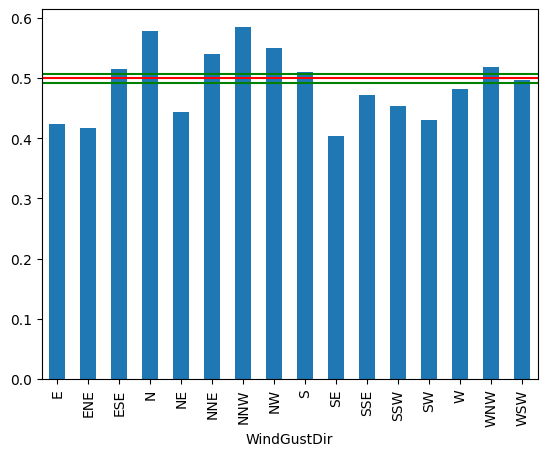

In [105]:
train = pd.concat([X_train, y_train], axis=1)

(train.groupby('WindGustDir')['RainTomorrow'].mean()).plot(kind = 'bar')
# Creamos una linea horizontal en el promedio de RainTomorrow
plt.axhline(y=media, color='r', linestyle='-')
plt.axhline(y=media + 2.5 * sd, color='g', linestyle='-')
plt.axhline(y=media - 2.5 * sd, color='g', linestyle='-')

In [106]:
# Creamos nueva variable 'WindGust' si esta dentro de alguna de las categorias
# que este por arriba de la media va a ser 1 si no 0
windgust = df.groupby('WindGustDir')['RainTomorrow'].mean()

X_train['WindGust'] = X_train['WindGustDir'].apply(lambda x: 1 if not pd.isnull(x) and windgust.get(x) > y_train.mean() else 0)
X_test['WindGust'] = X_test['WindGustDir'].apply(lambda x: 1 if not pd.isnull(x) and windgust.get(x) > y_train.mean() else 0)

X_train.drop('WindGustDir', axis=1, inplace=True)
X_test.drop('WindGustDir', axis=1, inplace=True)

### Matriz de correlación

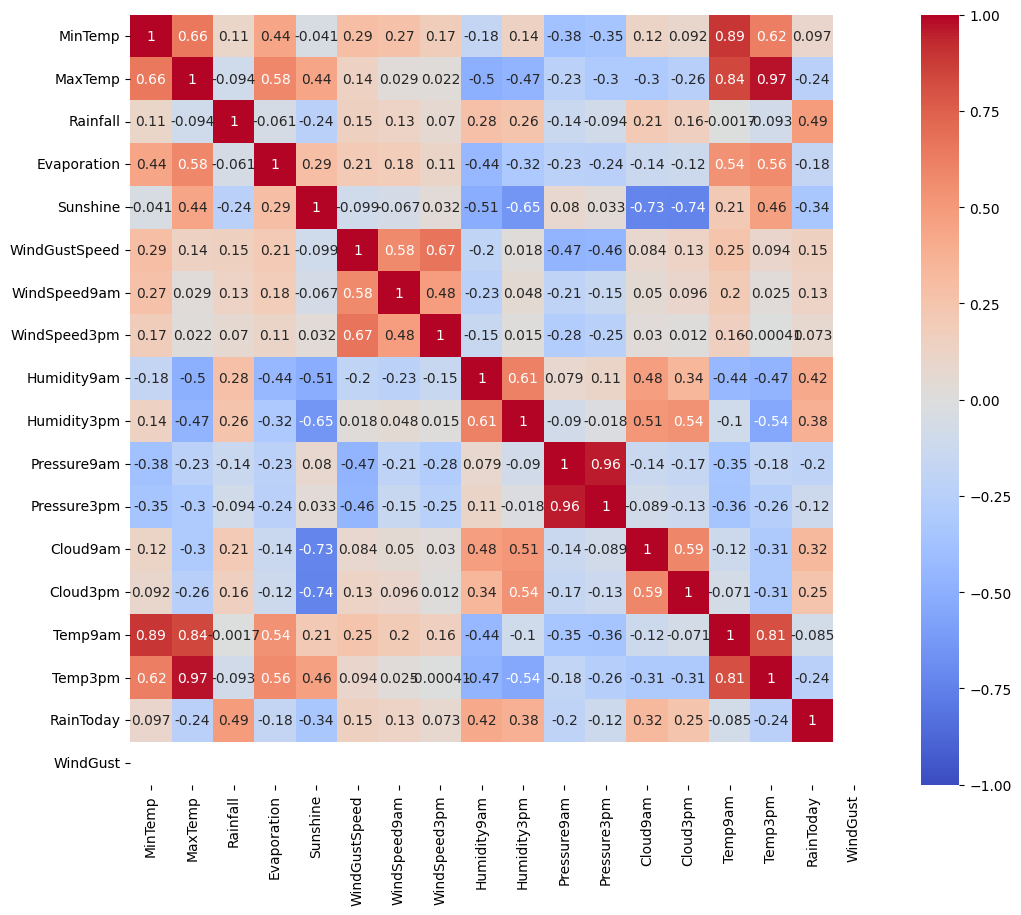

In [107]:
# Tomamos todas las variables numericas
df_train_num = X_train.select_dtypes(include=['int64', 'float64'])

# Creamos un heatmap con la correlacion de estas variables
plt.figure(figsize=(12, 10))
sns.heatmap(df_train_num.corr(), annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
plt.show()

Temp 9am y 3pm es correlacionado casi perfecto  con min y max temp respectivamente. Por lo que vamos a eliminar alguna de estas.

Ademas, Sunshine este altamente correlacionado negativamente con humidity y cloud tanto 9am como 3pm. Pero tiene mas nulls que las anteriores por lo que tambien dropeo esta fila a pesar de la buena correlacion que tiene con la variable respuesta

(La colinealidad de las variables afecta el modelo lineal)

Ademas, windspeed tanto 9am como 3pm no pareciera tener una correlacion grande por lo que tambien se eliminara

In [108]:
X_test = X_test.drop(['Temp3pm', 'Temp9am', 'Sunshine', 'WindSpeed9am', 'WindSpeed3pm', 'WindDir9am', 'WindDir3pm', 'Pressure9am'], axis=1)
X_train = X_train.drop(['Temp3pm', 'Temp9am', 'Sunshine', 'WindSpeed9am', 'WindSpeed3pm','WindDir9am', 'WindDir3pm', 'Pressure9am'], axis=1)

X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_train_cat = X_train.select_dtypes(include=['object'])

X_test_num = X_test.select_dtypes(include=['int64', 'float64'])
X_test_cat = X_test.select_dtypes(include=['object'])

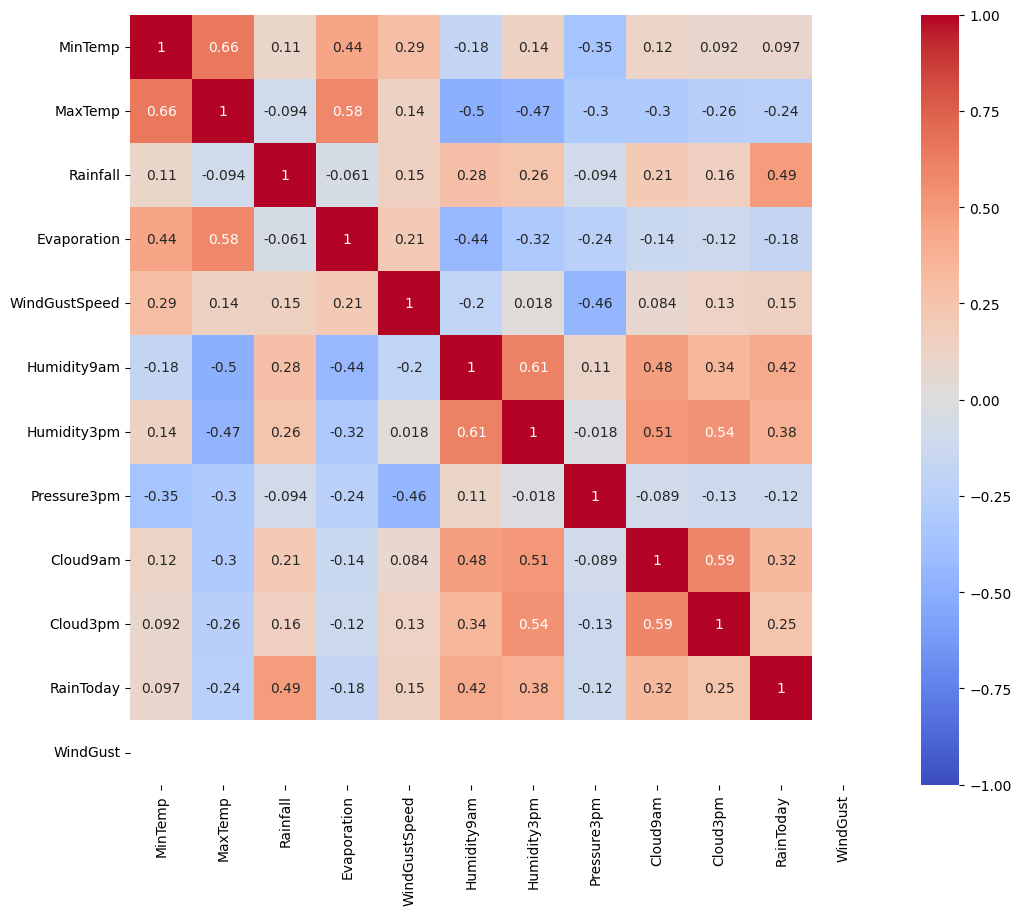

In [109]:
# Creamos un heatmap con la correlacion de las variables restantes
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_num.corr(), annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
plt.show()

### Visualización de las variables

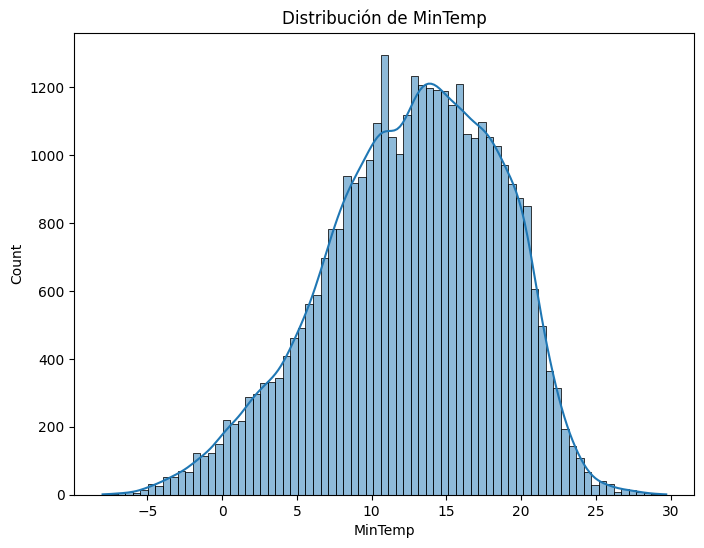

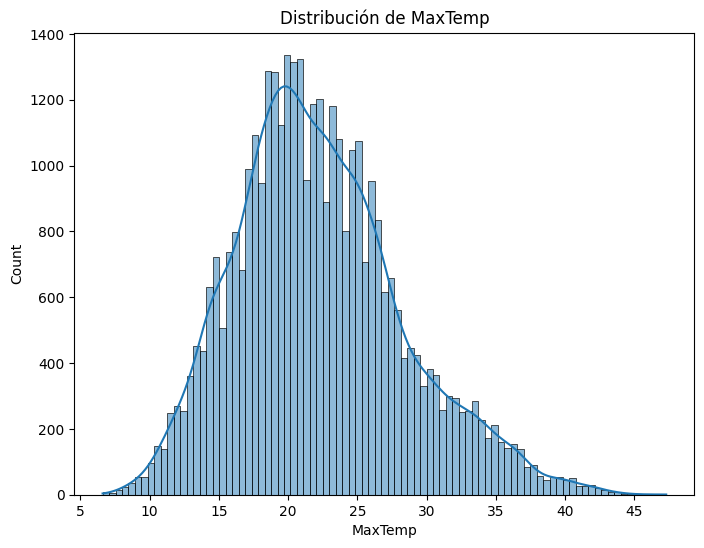

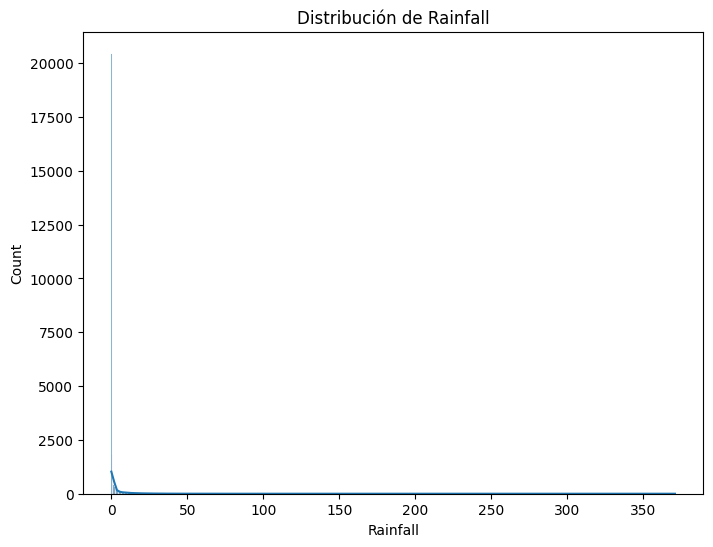

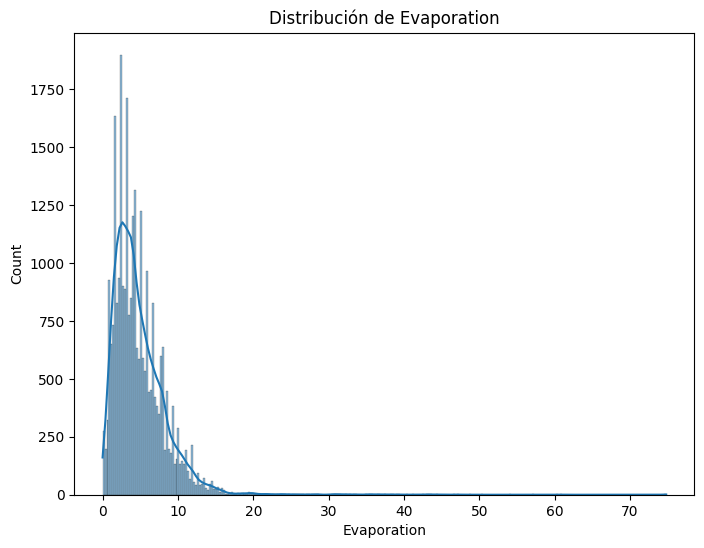

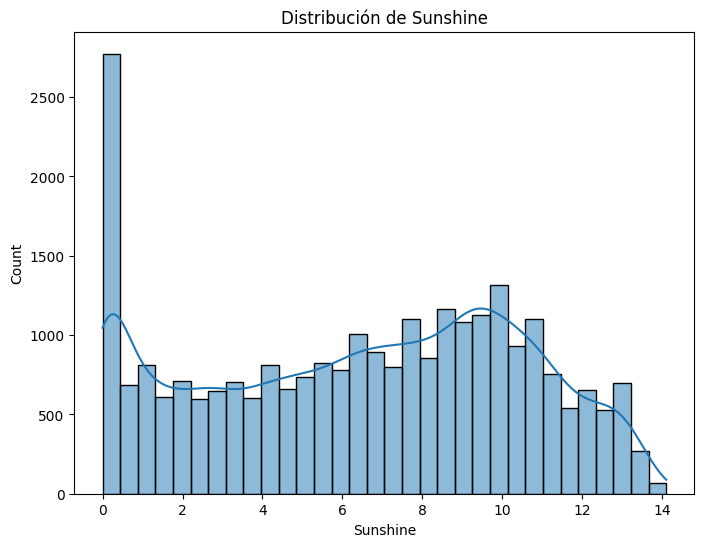

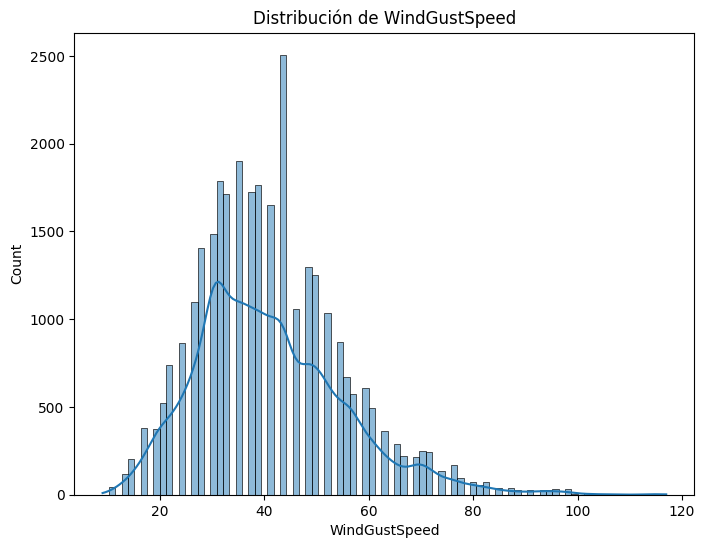

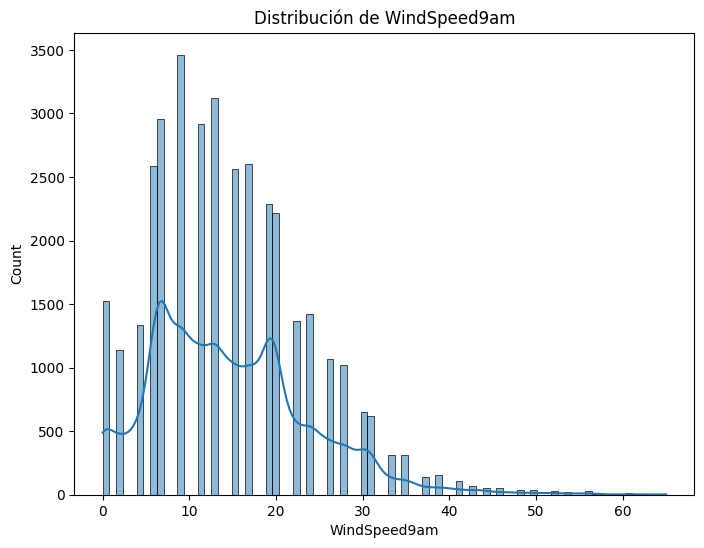

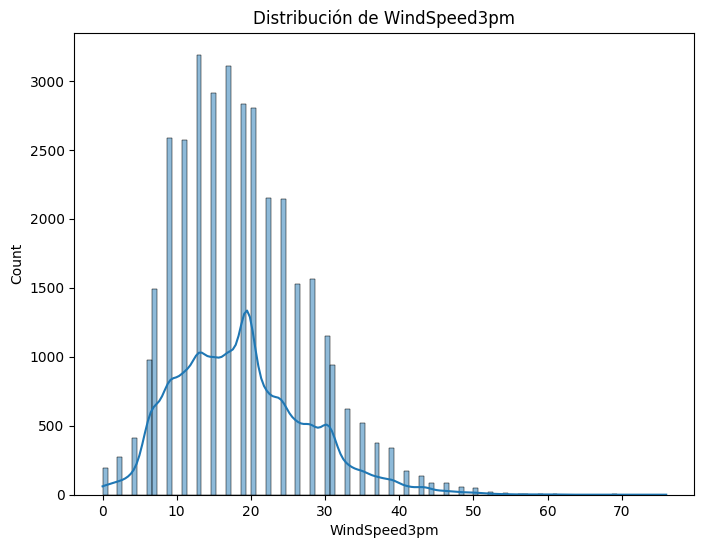

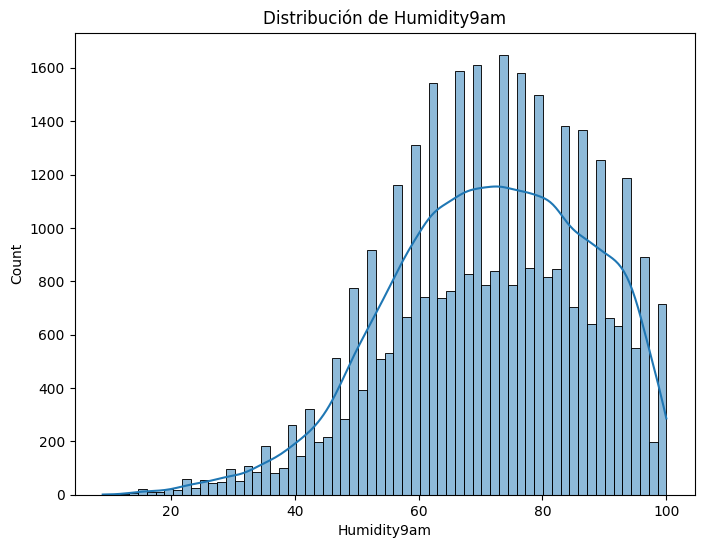

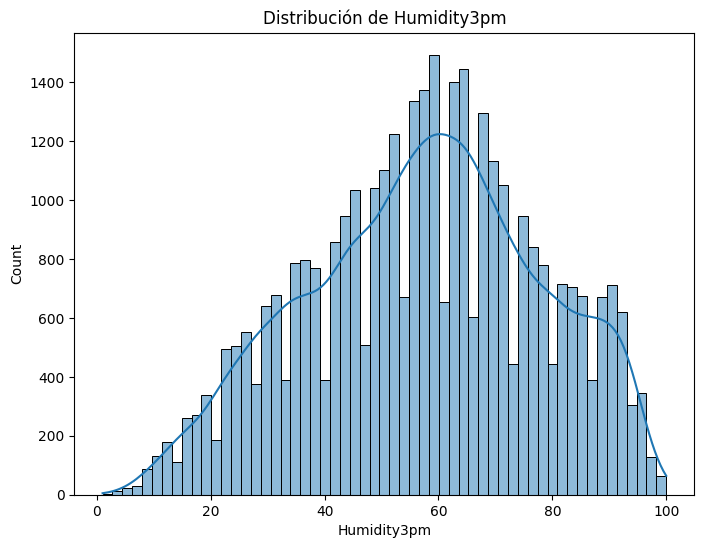

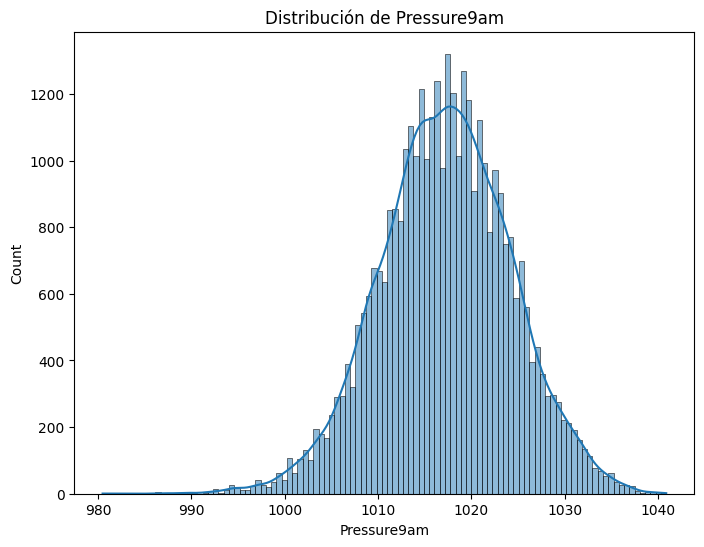

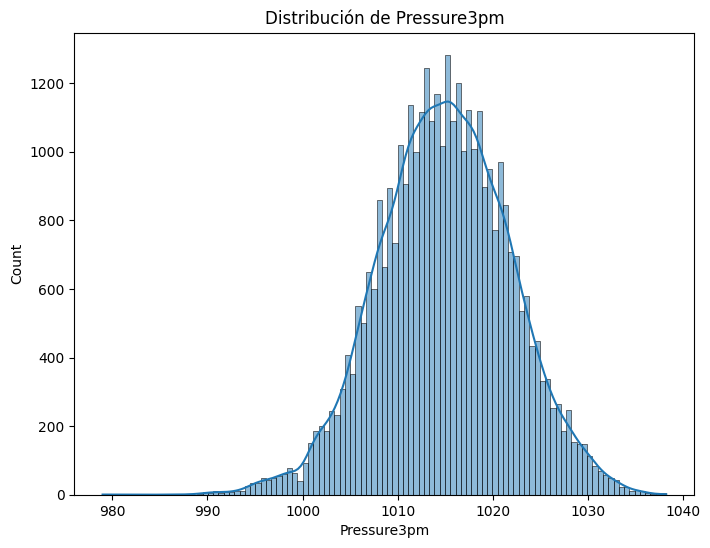

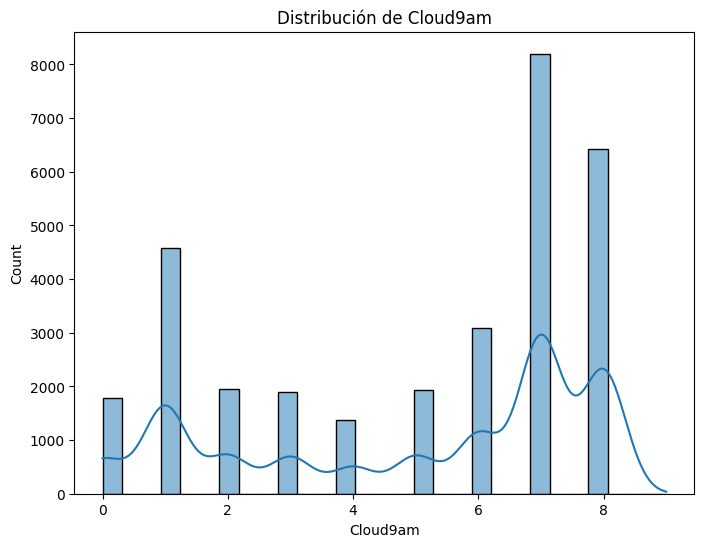

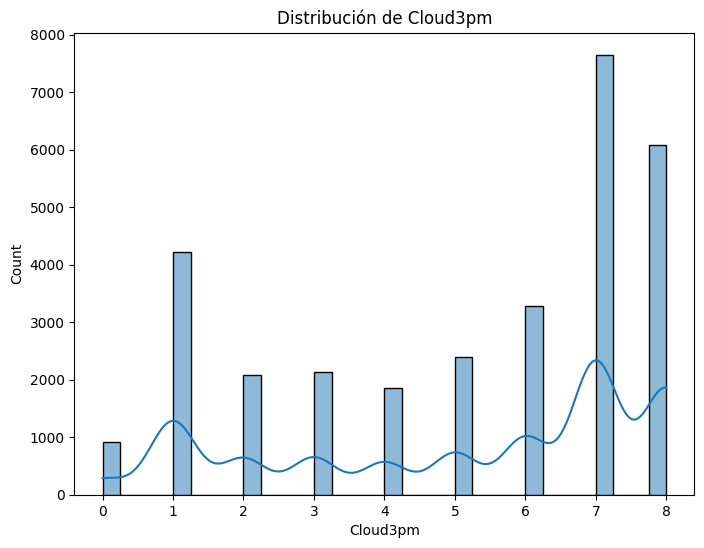

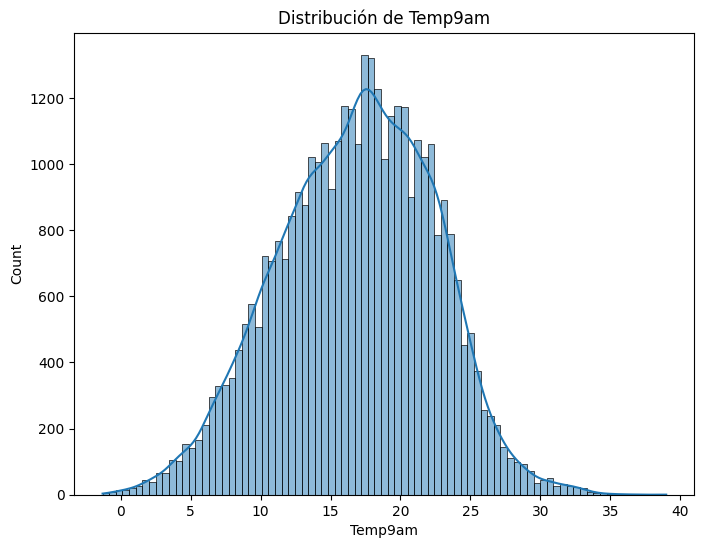

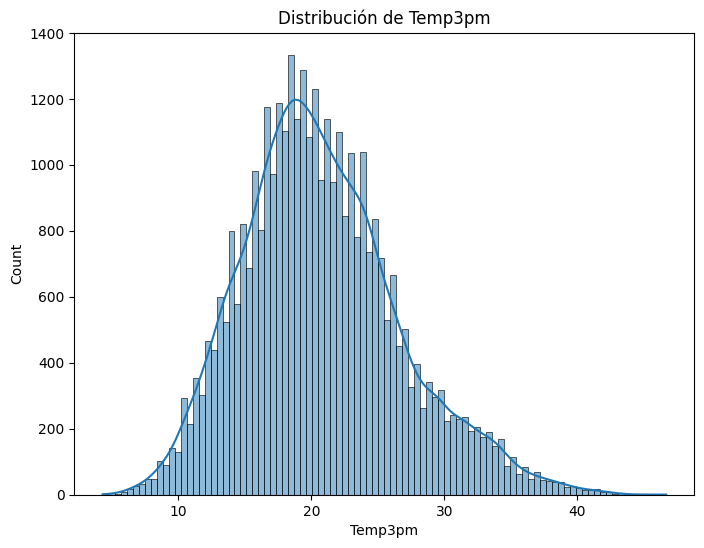

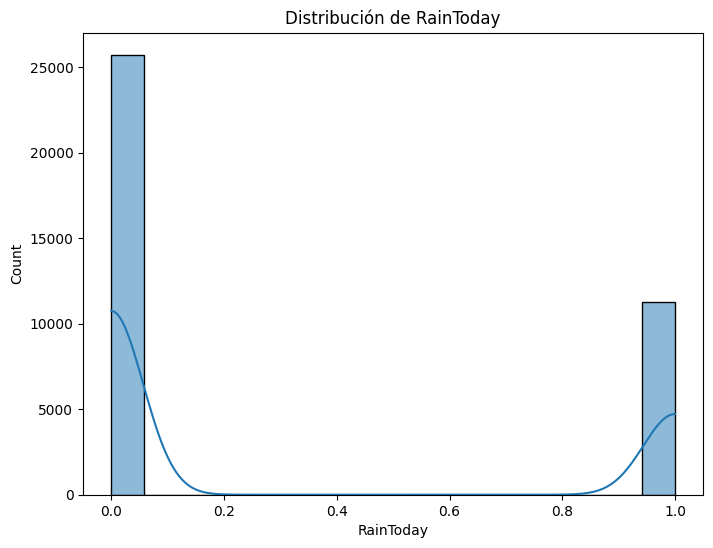

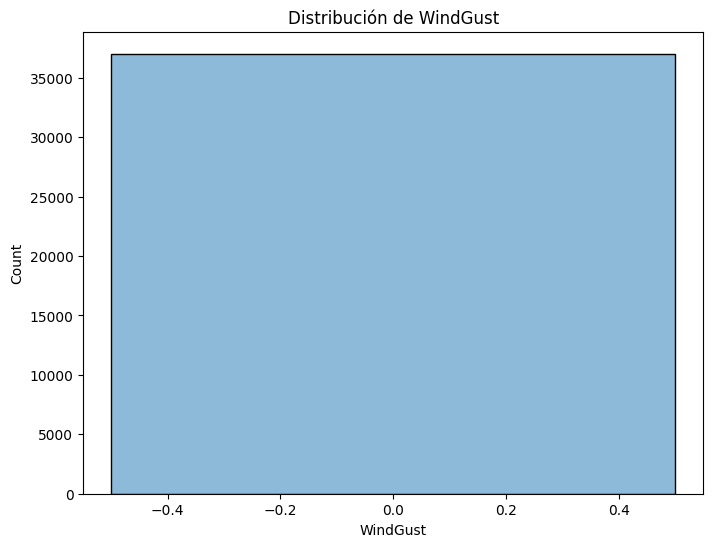

In [110]:
# Visualizamos las distribuciones de estas variables con seaborn
for col in df_train_num.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_train_num[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()

Parece que 2 variables (rainfall y evaporation) tienen 2 distribuciones muy asimetricas, capaz se podria transformar.

In [111]:
train.groupby('Cloud9am')['RainTomorrow'].mean()

,RainTomorrow
Cloud9am,
0.0,0.106061
1.0,0.253223
2.0,0.406330
3.0,0.432632
4.0,0.475983
5.0,0.506186
6.0,0.565330
7.0,0.629589
8.0,0.739835


Se nota que cloud9am y 3pm aunque sean variables categóricas son ordinales, esto quiere decir que 8 signfica que hay mas nubes que en 7, parece haber solo 2 observaciones con nivel 9, por lo que lo trataremos como datos mal imputados (la probabilidad de lluvia aumenta conforme es mas grande)

In [112]:
# Cambiamos las 2 observaciones con cloud9am = 9.0 a  0
X_train.loc[X_train['Cloud9am'] == 9.0, 'Cloud9am'] = 0
X_test.loc[X_test['Cloud9am'] == 9.0, 'Cloud9am'] = 0

In [113]:
# Dropeamos Date y Location
X_train = X_train.drop(['Date', 'Location'], axis=1)
X_test = X_test.drop(['Date', 'Location'], axis=1)

In [114]:
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])

### Estandarización

In [115]:
cols = X_train_num.columns
cols.drop(labels = ['RainToday', 'WindGust'])

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed',
       'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm'],
      dtype='object')

In [116]:
# Normalizamos con PowerScaler las columnas numericas
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

### Análisis y decisión sobre datos faltantes

In [117]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed',
       'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'RainToday', 'WindGust'],
      dtype='object')

In [118]:
sqrt(len(X_train))

192.43180610283738

In [119]:
# Imputamos la moda en las varibles categoricas (RainToday, Windgust)
RainToday_mode = X_train['RainToday'].mode()[0]
X_train['RainToday'].fillna(RainToday_mode, inplace=True)
X_test['RainToday'].fillna(RainToday_mode, inplace=True)

WindGust_mode = X_train['WindGust'].mode()[0]
X_train['WindGust'].fillna(WindGust_mode, inplace=True)
X_test['WindGust'].fillna(WindGust_mode, inplace=True)


# Completamos datos faltantes por kmeans

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=155)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)


<ipython-input-119-95cabb14a518>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['RainToday'].fillna(RainToday_mode, inplace=True)
<ipython-input-119-95cabb14a518>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [120]:
(abs(X_train) > 3).sum()

,0
MinTemp,3
MaxTemp,45
Rainfall,0
Evaporation,89
WindGustSpeed,77
Humidity9am,0
Humidity3pm,0
Pressure3pm,103
Cloud9am,0
Cloud3pm,0


## Consigna 2

### Implementamos el modelo de clasificación con regresión logística

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

logreg = LogisticRegression(random_state=0, max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

### Cálculo de métricas

In [122]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")        # Promedio ponderado entre presición y recall

Accuracy: 0.768848563404623
Precision: 0.7717391304347826
Recall: 0.7650862068965517
F1 Score: 0.7683982683982684


### Matriz de confusión

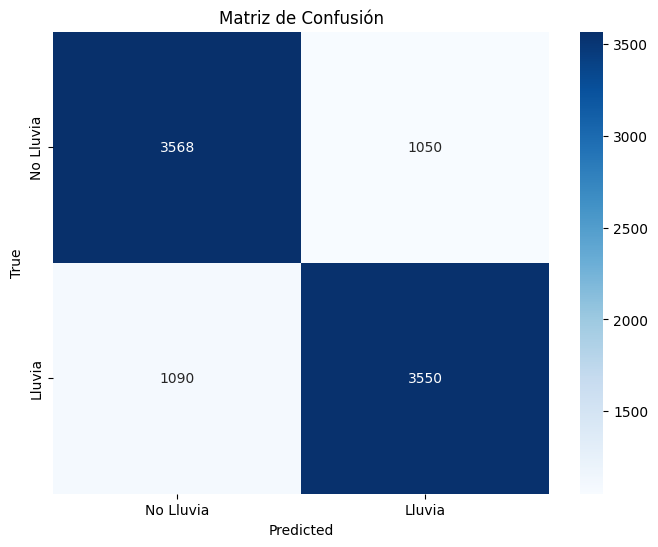

In [123]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lluvia", "Lluvia"], yticklabels=["No Lluvia", "Lluvia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.show()

Falsos positivos: Casos en que se predice lluvia para el día siguiente, pero que no sucedió.

Falsos negativos: Casos en que se predice que no lloverá al día siguiene y luego llueve.

### Curva ROC y el AUC

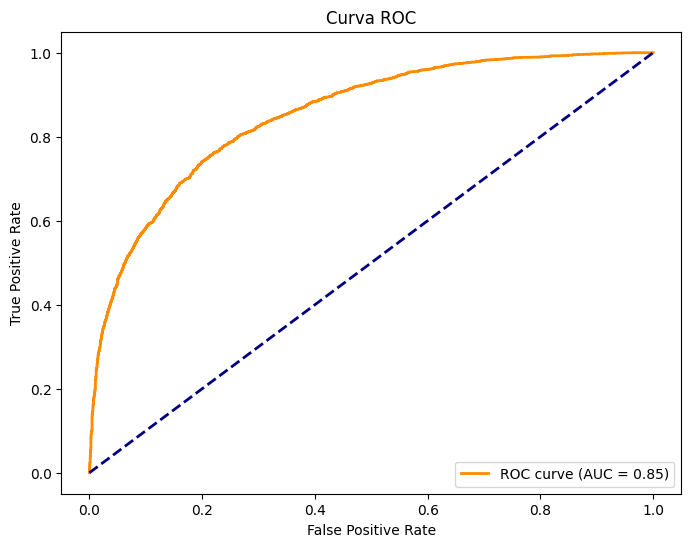

In [124]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Analizar el mejor umbral

In [135]:
for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    precision_adjusted = precision_score(y_test, y_pred_adjusted)
    recall_adjusted = recall_score(y_test, y_pred_adjusted)
    f1_adjusted = f1_score(y_test, y_pred_adjusted)
    #print(f"Threshold: {threshold:.2f}, Precision: {precision_adjusted:.2f}, Recall: {recall_adjusted:.2f}, F1: {f1_adjusted:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold: 0.46, Precision: 0.75, Recall: 0.80, F1: 0.78

Threshold: 0.35, Precision: 0.70, Recall: 0.87, F1: 0.78


AUC : (El área bajo la curva es de 0.83, lo cual indica un modelo aceptable, recordando que un modelo aleatorio tendría un área de 0.5)



Dependiendo la métrica que quiera optimizarse, pueden elegirse diferentes umbrales.
Los umbrales que maximizan F1 (buscaría un mejor equilibrio entre presición y recall) se encuentran entre 0.35 y 0.46.

En ese rango de umbral, podríamos optar por maximizar Presición o Recall dependiendo lo que se busque en contexto. Maximizar presición podría predecir lluvia cuando en realidad no suceda, y viceversa con recall, no predecir lluvia cuando en realidad si suceda.

## Consigna 3

### Entrenamos del modelo base con RandomForestClassifier

In [126]:
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

### Implementamos el modelo de clasificación con modelo base

In [127]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      4618
           1       0.91      0.97      0.94      4640

    accuracy                           0.94      9258
   macro avg       0.94      0.94      0.94      9258
weighted avg       0.94      0.94      0.94      9258



### Matriz de confusión

In [128]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", conf_matrix)

Matriz de confusión:
 [[4181  437]
 [ 124 4516]]


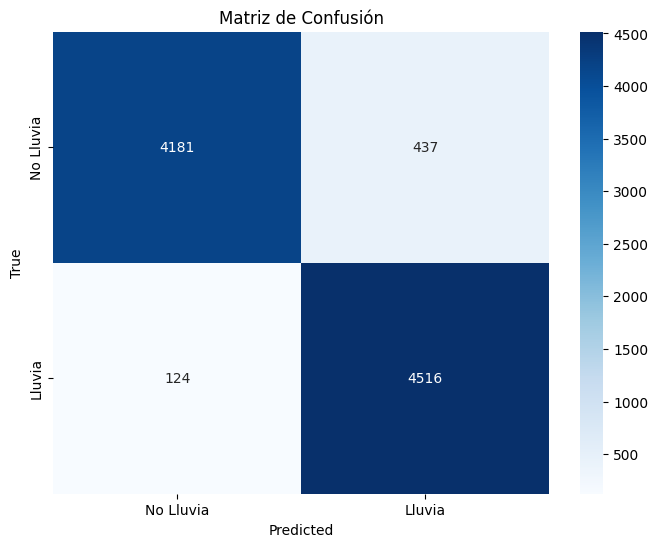

In [129]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lluvia", "Lluvia"], yticklabels=["No Lluvia", "Lluvia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.show()

Falsos positivos: Casos en que se predice lluvia para el día siguiente, pero que no sucedió.

Falsos negativos: Casos en que se predice que no lloverá al día siguiene y luego llueve.

### Curva ROC y el AUC

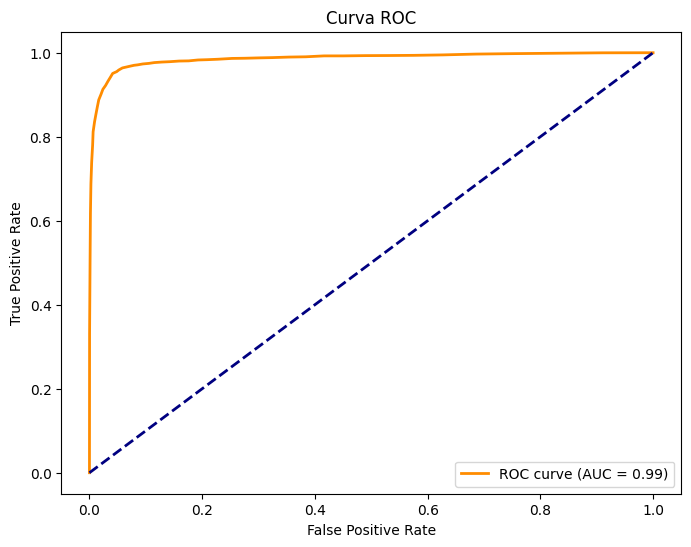

In [130]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Selección de un umbral

In [131]:
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

F1 Score: 0.9415198582299593


In [134]:
for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    precision_adjusted = precision_score(y_test, y_pred_adjusted)
    recall_adjusted = recall_score(y_test, y_pred_adjusted)
    f1_adjusted = f1_score(y_test, y_pred_adjusted)
    #print(f"Threshold: {threshold:.2f}, Precision: {precision_adjusted:.2f}, Recall: {recall_adjusted:.2f}, F1: {f1_adjusted:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold: 0.74, Precision: 0.97, Recall: 0.92, F1: 0.95

Threshold: 0.56, Precision: 0.92, Recall: 0.97, F1: 0.95

AUC : (El área bajo la curva es de 0.99, lo cual indica un modelo con altos valores de presición)

Dependiendo la métrica que quiera optimizarse, pueden elegirse diferentes umbrales. Los umbrales que maximizan F1 (buscaría un mejor equilibrio entre presición y recall) se encuentran entre 0.56 y 0.74.

En ese rango de umbral, podríamos optar por maximizar Presición o Recall dependiendo lo que se busque en contexto. Maximizar presición podría predecir lluvia cuando en realidad no suceda, y viceversa con recall, no predecir lluvia cuando en realidad si suceda.

Hemos conseguido un alto fitting con modelo base, muy por encima de el modelo con regresión logística.